In [254]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import wordcloud
import langdetect
import spacy

from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

from tensorflow.keras import models,layers,preprocessing as kprocessing
from tensorflow.keras import backend as K

import transformers

import numpy as np

In [200]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [201]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [202]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [203]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. NEED to remove that in AWS

In [204]:
df = get_samples(df,100000)

In [205]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [206]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer

In [207]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A
250885,7,is there anyone out there who needs a new friend?,i need someone i can talk to im loosing my min...,Talk to me friend. email me at mhasalek@yahoo....,is there anyone out there who needs a new frie...,is there anyone out there who needs a new frie...
1035828,2,a question in math?,"We all know that, if we want to know is a numb...",Numerals whose sum of digits is divisible by 3...,"a question in math?We all know that, if we wan...","a question in math?We all know that, if we wan..."
22614,7,can somebody help me?,,"Yes. You. If you don't help yourself, no one...",can somebody help me?,can somebody help me?Yes. You. If you don't ...
1195019,7,How can I reduce my tax payable income to save...,"There may be certain govt bonds, investments t...",YOU SHOULD GET PAID NOT TAXED!\n\n\nThe Alaska...,How can I reduce my tax payable income to save...,How can I reduce my tax payable income to save...
203659,3,Is it a good idea to take specially formulated...,Some sources say it is difficult to get all th...,Since you may be in the process of getting pre...,Is it a good idea to take specially formulated...,Is it a good idea to take specially formulated...


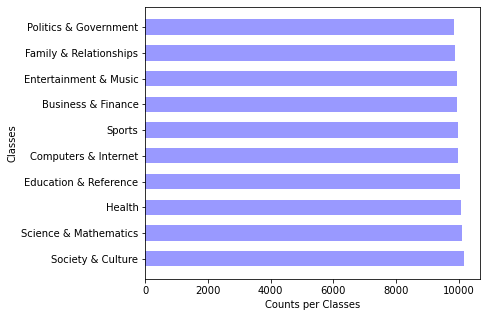

In [208]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [209]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [210]:
lst_stopwords = stopwords.words('english')

In [211]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [212]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [213]:
df.head(10)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new
250885,7,is there anyone out there who needs a new friend?,i need someone i can talk to im loosing my min...,Talk to me friend. email me at mhasalek@yahoo....,is there anyone out there who needs a new frie...,is there anyone out there who needs a new frie...,anyone need new friend need someone talk im lo...
1035828,2,a question in math?,"We all know that, if we want to know is a numb...",Numerals whose sum of digits is divisible by 3...,"a question in math?We all know that, if we wan...","a question in math?We all know that, if we wan...",question math know want know number devidable ...
22614,7,can somebody help me?,,"Yes. You. If you don't help yourself, no one...",can somebody help me?,can somebody help me?Yes. You. If you don't ...,somebody help yes help one else
1195019,7,How can I reduce my tax payable income to save...,"There may be certain govt bonds, investments t...",YOU SHOULD GET PAID NOT TAXED!\n\n\nThe Alaska...,How can I reduce my tax payable income to save...,How can I reduce my tax payable income to save...,reduce tax payable income save money usa speci...
203659,3,Is it a good idea to take specially formulated...,Some sources say it is difficult to get all th...,Since you may be in the process of getting pre...,Is it a good idea to take specially formulated...,Is it a good idea to take specially formulated...,good idea take specially formulated vitamin su...
195402,6,what is the fastest production vehicle?,,"to date: the Bugatti Veyron, top speed of 253m...",what is the fastest production vehicle?,what is the fastest production vehicle?to date...,fastest production vehicle date bugatti veyron...
854159,8,The song:L is 4 the way you look at me; O is 4...,this is song sang by Nat King; but there is th...,"Natalie Cole, Nat King Cole's daughter, made s...",The song:L is 4 the way you look at me; O is 4...,The song:L is 4 the way you look at me; O is 4...,song l 4 way look 4 1 song sang nat king versi...
87173,7,how long does mardi gras last??,,"Usually the carnival season last for 12 days, ...",how long does mardi gras last??,how long does mardi gras last??Usually the ...,long mardi gras last usually carnival season l...
298352,6,Why do people hate John Cena?,Over the past few weeks loud boo's can be hear...,I think its because when he started becoming a...,Why do people hate John Cena?Over the past few...,Why do people hate John Cena?Over the past few...,people hate john cena past week loud boo heard...
449095,9,what can i do to change her thoughts to let he...,there was a big pressure on my gf from me she ...,"Let it go and be a friend. Afterall, that sou...",what can i do to change her thoughts to let he...,what can i do to change her thoughts to let he...,change thought let love back big pressure gf s...


In [214]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [215]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
250885,7,is there anyone out there who needs a new friend?,i need someone i can talk to im loosing my min...,Talk to me friend. email me at mhasalek@yahoo....,is there anyone out there who needs a new frie...,is there anyone out there who needs a new frie...,anyone need new friend need someone talk im lo...,69,255,5,3.695652,13.800000
1035828,2,a question in math?,"We all know that, if we want to know is a numb...",Numerals whose sum of digits is divisible by 3...,"a question in math?We all know that, if we wan...","a question in math?We all know that, if we wan...",question math know want know number devidable ...,354,1355,33,3.827684,10.727273


In [216]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

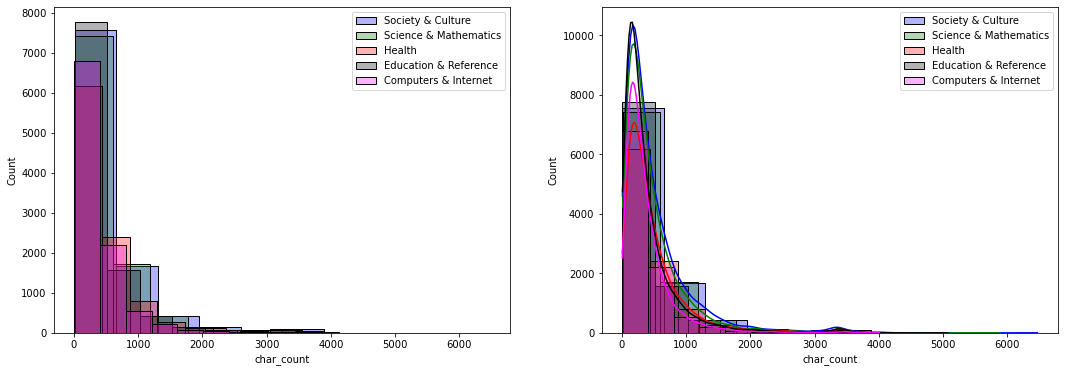

In [217]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [218]:
df.groupby('target').word_count.median()

target
1     72
2     66
3     75
4     52
5     58
6     45
7     52
8     41
9     74
10    73
Name: word_count, dtype: int64

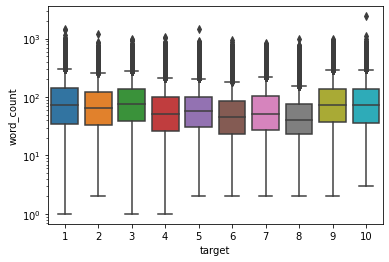

In [219]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

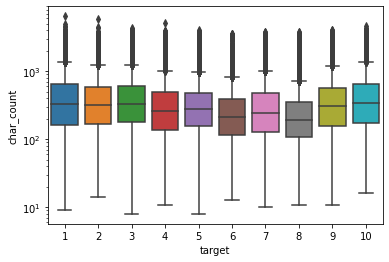

In [220]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

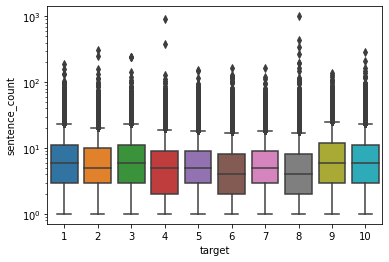

In [221]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

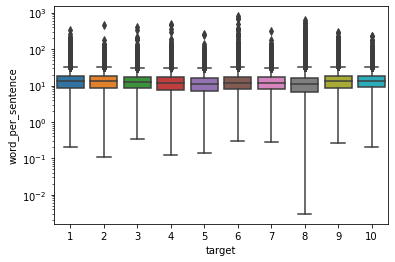

In [222]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [239]:
X = df.Text_new
y = df.target

In [240]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [241]:
vect = TfidfVectorizer(max_features=10000,ngram_range=(1,2))

In [242]:
vect.fit(X_train)

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [243]:
# X_train is the raw data
# XX_train is the matrix based on the X_train
XX_train = vect.transform(X_train)

In [244]:
vocab = vect.vocabulary_

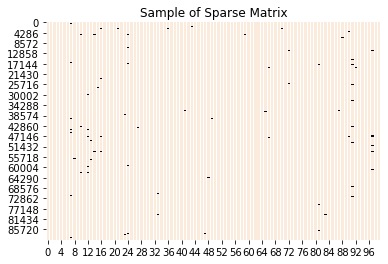

In [245]:
sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [262]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    #df_features = df_features.sort_values(["y","Score"],ascending=[True,False])


In [33]:
count = CountVectorizer(stop_words=lst_stopwords,max_features=5000,max_df=20,min_df=2)

In [ ]:
# Creating a cloud of words

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [178]:
nb = naive_bayes.MultinomialNB()

In [179]:
# pipeline
model = pipeline.Pipeline([("vectorizer",vect),
                           ("classifier",nb)])

In [180]:
cross_val_score(model,X_train,y_train,cv=5,n_jobs=-1)

array([0.66527778, 0.67161111, 0.668     , 0.67022222, 0.67422222])

In [169]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('classifier', MultinomialNB())])

In [170]:
## Test Classifier
Predicted = model.predict(X_test)
Predicted_prob = model.predict_proba(X_test)

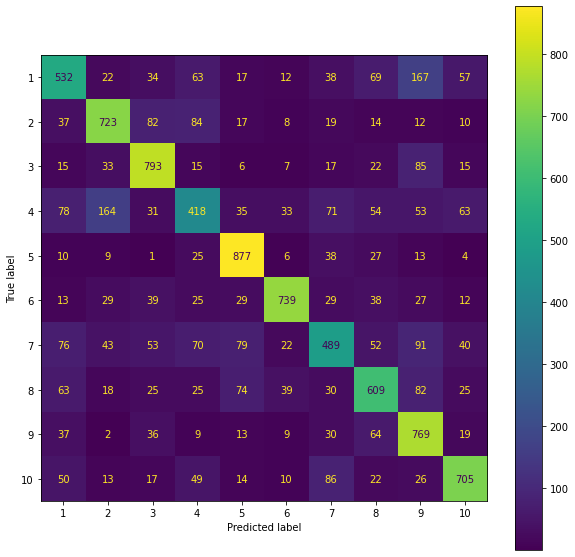

In [177]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model,X_test,y_test,ax=ax);

### Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [187]:
lr = LogisticRegression(max_iter=5000)

In [188]:
# pipeline
model_lr = pipeline.Pipeline([("vectorizer",vect),
                           ("classifier",lr)])

In [189]:
cross_val_score(model_lr,X_train,y_train,cv=5,n_jobs=-1)

array([0.67572222, 0.67666667, 0.67955556, 0.68055556, 0.68733333])

In [190]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('classifier', LogisticRegression(max_iter=5000))])

In [191]:
## Test Classifier
Predicted = model_lr.predict(X_test)
Predicted_prob = model_lr.predict_proba(X_test)

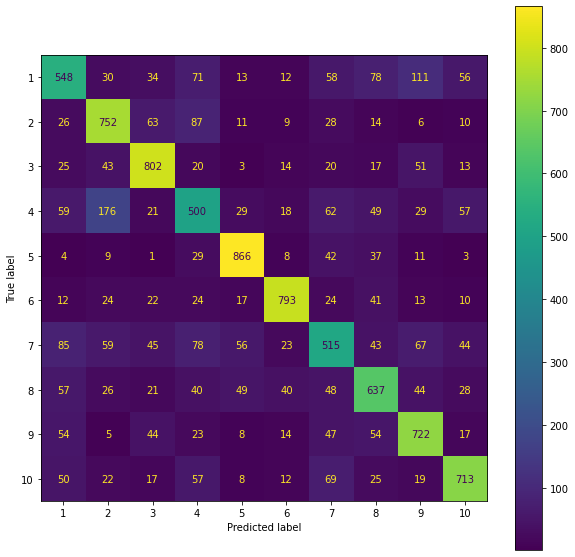

In [192]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,X_test,y_test,ax=ax);

In [ ]:
vectorizer = TfidfVectorizer(stop_words=lst_stopwords,min_df=5,max_features=5000)

In [ ]:
vec_df = vectorizer.fit_transform(df['Q&A'])

In [ ]:
vec_df.shape

In [ ]:
features_name = vectorizer.get_feature_names()

In [ ]:
X_vec = vec_df
A = np.squeeze(np.asarray(X_vec.sum(axis=0)))
A = pd.Series(A)

In [ ]:
v =  A.sort_values(ascending=False)[:20]
top_words_index = A.sort_values(ascending=False).index[:20]
top_words_index

In [ ]:
top_words=[]
for i in top_words_index:
    top_words.append(features_name[i])
    
top_words